In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from PIL import Image
from pathlib import Path
from matplotlib.patches import Rectangle
from scipy.io import loadmat
import cv2
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns
import albumentations as A

## Load DataFrame with Pathing

In [3]:
df = pd.read_csv('data/POC_imagedata.csv')

In [4]:
df.head()

,Country,Latitude,Longitude,Pano_Id,Path
0,Spain,36.477286,-5.880578,mnPCQWYwG-MIUV64ybl23g,data/images/Spain/0000/
1,Spain,37.600117,-4.341563,cXqaOBEMHANps9ZENoLozw,data/images/Spain/0001/
2,Spain,42.870488,-1.381516,RHuZZGXpb4levD1LK8Wtsw,data/images/Spain/0002/
3,Spain,41.296693,-3.603524,si-40KyaaKHFGdvy12nSIg,data/images/Spain/0003/
4,Spain,39.024927,-3.977601,wniI8AxaJ2gBC7q1GjV7GQ,data/images/Spain/0004/


In [5]:
#df = df.sample(1000)

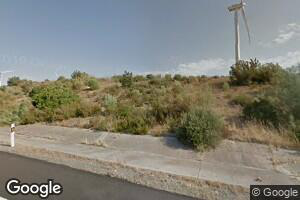

In [6]:
Image.open(df.Path.iloc[0] + 'N.jpg')

## Create Train / Validation Sets

In [7]:
train, val = train_test_split(df, test_size=0.20, stratify=df.Country.values)

In [8]:
train.shape

(2400, 5)

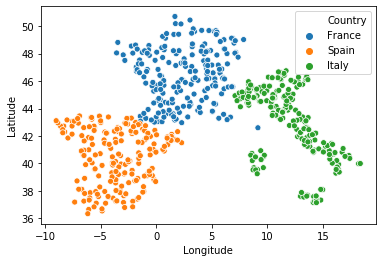

In [9]:
sns.scatterplot(x='Longitude', y='Latitude', data=val, hue='Country')

## Dataset

In [10]:
def img_to_np(fullpath):
    x = cv2.imread(fullpath).astype(np.uint8)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

In [11]:
def stitch_panos(path):
    return np.concatenate([img_to_np(path + direction + '.jpg') for direction in 'NESW'], axis=1)

#### Data Augmentation Functions

In [12]:
transforms = A.Compose([
        A.RandomCrop(height=150, width=900),
        A.HorizontalFlip(p=0.5),
        A.GaussNoise(p=0.15),
        A.OneOf([
            A.MotionBlur(p=0.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=22.5, p=0.25),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.IAASharpen(),
            A.IAAEmboss(),
            A.RandomBrightnessContrast(),            
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
        A.Normalize()
    ])

no_transforms = A.Compose([
        A.CenterCrop(height=150, width=900),
        A.Normalize()
])

In [13]:
class GeoDataset(Dataset):
    def __init__(self, df, transform=False):
        self.paths = [p for p in df.Path.values]
        self.lat = [lat for lat in df.Latitude.values]
        self.long = [long for long in df.Longitude.values]
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        lat = self.lat[idx]
        long = self.long[idx]
        x = stitch_panos(self.paths[idx])
        
        if self.transform:
            x = transforms(image=x)['image']
        else:
            x = no_transforms(image=x)['image']
        x = np.rollaxis(x, 2)
        
        return x, lat, long

In [14]:
train_ds = GeoDataset(train, transform=True)
valid_ds = GeoDataset(val)

In [15]:
x, y1, y2 = train_ds[1]
x.shape, y1, y2

((3, 150, 900), 42.7485819, 0.5818106)

## Model

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet18(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features1 = nn.Sequential(*layers[:6])
        self.features2 = nn.Sequential(*layers[6:])
        self.lat_linear = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 128), nn.ReLU(), 
                                        nn.Dropout(), nn.Linear(128, 1))
        self.long_linear = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 128), nn.ReLU(), 
                                        nn.Dropout(), nn.Linear(128, 1))
        self.dropout = nn.Dropout()
        
    def forward(self, x):
        x = self.features1(x)
        x = self.features2(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        lat = self.lat_linear(self.dropout(x))
        long = self.long_linear(self.dropout(x))
        return lat, long

In [17]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0 
    for x, lat, long in valid_dl:
        batch = lat.shape[0]
        x = x.cuda().float()
        lat, long = lat.cuda().float(), long.cuda().float()
        lt, lng = model(x)
        lat_loss = F.mse_loss(lt, lat.unsqueeze(1))
        long_loss = F.mse_loss(lng, long.unsqueeze(1))
        loss = lat_loss + long_loss
        sum_loss += loss.item()
        total += batch
    return sum_loss/total

In [18]:
def train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=10):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    optimizer = create_optimizer2(model, lrs[0])
    prev_val_acc = 0.0
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for x, lat, long in train_dl:
            lr = lrs[idx]
            update_optimizer2(optimizer, [lr/20, lr/10, lr, lr])
            batch = lat.shape[0]
            x = x.cuda().float()
            lat, long = lat.cuda().float(), long.cuda().float()
            lt, lng = model(x)
            lat_loss = F.mse_loss(lt, lat.unsqueeze(1))
            long_loss = F.mse_loss(lng, long.unsqueeze(1))
            loss = lat_loss + long_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total += batch
            sum_loss += loss.item()
            idx += 1
        train_loss = sum_loss/total
        val_loss = val_metrics(model, valid_dl)
        print("train_loss %.3f val_loss %.3f" % (train_loss, val_loss))
#         if val_acc > prev_val_acc: 
#             prev_val_acc = val_acc
#             if val_acc > 0.75:
#                 path = "data/models/model_resnet18_stitch_loss_{0:.0f}.pth".format(100*val_acc)
#                 save_model(model, path)
#                 print(path)
#     return path

In [19]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

In [20]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations):
    min_start, min_end = max_lr/25, max_lr/(25*1e4)
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

In [21]:
def create_optimizer2(model, lr0):
    params = [{'params': model.features1.parameters(), 'lr': lr0/50},
              {'params': model.features2.parameters(), 'lr': lr0/20},
              {'params': model.lat_linear.parameters(), 'lr': lr0},
              {'params': model.long_linear.parameters(), 'lr': lr0}]
    return optim.Adam(params, weight_decay=1e-5)

def update_optimizer2(optimizer, group_lrs):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = group_lrs[i]

In [22]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [23]:
model = Net().cuda()

In [24]:
val_metrics(model, valid_dl)

32.274409993489584

In [25]:
best_path = train_epochs(model, train_dl, valid_dl, max_lr=0.001, epochs=30)

train_loss 30.900 val_loss 32.353
train_loss 30.690 val_loss 32.126
train_loss 30.181 val_loss 30.746
train_loss 27.029 val_loss 17.327
train_loss 12.124 val_loss 7.514
train_loss 5.771 val_loss 3.745
train_loss 3.276 val_loss 1.535
train_loss 2.230 val_loss 1.255
train_loss 2.024 val_loss 1.016
train_loss 1.887 val_loss 1.221
train_loss 1.835 val_loss 0.987
train_loss 1.724 val_loss 0.991
train_loss 1.767 val_loss 0.986
train_loss 1.701 val_loss 1.206
train_loss 1.686 val_loss 0.950
train_loss 1.614 val_loss 0.867
train_loss 1.584 val_loss 0.891
train_loss 1.524 val_loss 0.881
train_loss 1.515 val_loss 0.963
train_loss 1.450 val_loss 0.769
train_loss 1.471 val_loss 0.785
train_loss 1.374 val_loss 0.808


KeyboardInterrupt: 

## Prediction Evaluation

In [ ]:
#best_model = Net().cuda()
#load_model(best_model, best_path)

In [26]:
val.head()

,Country,Latitude,Longitude,Pano_Id,Path
1330,France,43.768582,5.053284,rFxEreGf8V6oxESETVDjIQ,data/images/France/0330/
1566,France,48.034994,-2.111296,BtwHgHqD1971NPIexIgnPg,data/images/France/0566/
794,Spain,41.766213,1.617388,ZpjXZg27jyHe-ROwufNkmQ,data/images/Spain/0794/
2336,Italy,44.519679,9.301202,Lu5XL4yXpqMlYw9wBqQjbA,data/images/Italy/0336/
1508,France,43.931482,-0.738579,LOfmDlNMbWMCHUdvRZGJ7w,data/images/France/0508/


In [27]:
lt_preds, lng_preds = [], []
with torch.no_grad():
    model.eval()
    for x, _, _ in valid_dl:
        lt, lng = model(x.cuda().float())
        lt = lt.cpu().detach().numpy()
        lt_preds += [p[0] for p in lt]
        lng = lng.cpu().detach().numpy()
        lng_preds += [p[0] for p in lng]

In [28]:
len(lt_preds), len(lng_preds)

(600, 600)

In [29]:
val['Lat_Pred'] = lt_preds
val['Long_Pred'] = lng_preds

In [30]:
val.head()

,Country,Latitude,Longitude,Pano_Id,Path,Lat_Pred,Long_Pred
1330,France,43.768582,5.053284,rFxEreGf8V6oxESETVDjIQ,data/images/France/0330/,42.828960,2.037889
1566,France,48.034994,-2.111296,BtwHgHqD1971NPIexIgnPg,data/images/France/0566/,40.557724,3.917936
794,Spain,41.766213,1.617388,ZpjXZg27jyHe-ROwufNkmQ,data/images/Spain/0794/,37.780045,-1.914179
2336,Italy,44.519679,9.301202,Lu5XL4yXpqMlYw9wBqQjbA,data/images/Italy/0336/,40.143681,7.490410
1508,France,43.931482,-0.738579,LOfmDlNMbWMCHUdvRZGJ7w,data/images/France/0508/,43.533669,3.867509


In [31]:
val.Lat_Pred.min(), train.Latitude.min()

(22.215757369995117, 36.231200534229714)

In [32]:
val.Long_Pred.min(), train.Longitude.min()

(-4.970197677612305, -9.250220592161133)

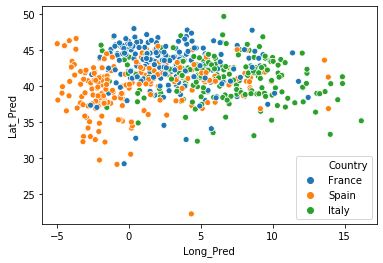

In [33]:
sns.scatterplot(x='Long_Pred', y='Lat_Pred', data=val, hue='Country')